<a href="https://colab.research.google.com/github/bogdnnx/prikoli1/blob/master/MOVR(fin).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Анализ временного ряда криптовалют **

# 1) **Для начала подготовим все необходимые либы для успешного и удобного выполнения прокта без изобретения велосипеда **


In [43]:
!pip install yfinance statsmodels matplotlib pandas pmdarima
!pip install pycoingecko

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.signal import detrend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from pycoingecko import CoinGeckoAPI



**Загрузка временного ряда** Для того чтобы проанализировать какую-либо монету необходимо ввести её тикер, например: BTC, ETH, DOGE и тд.



Введите идентификатор монеты (например, 'bitcoin', 'ethereum', 'dogecoin'): bitcoin


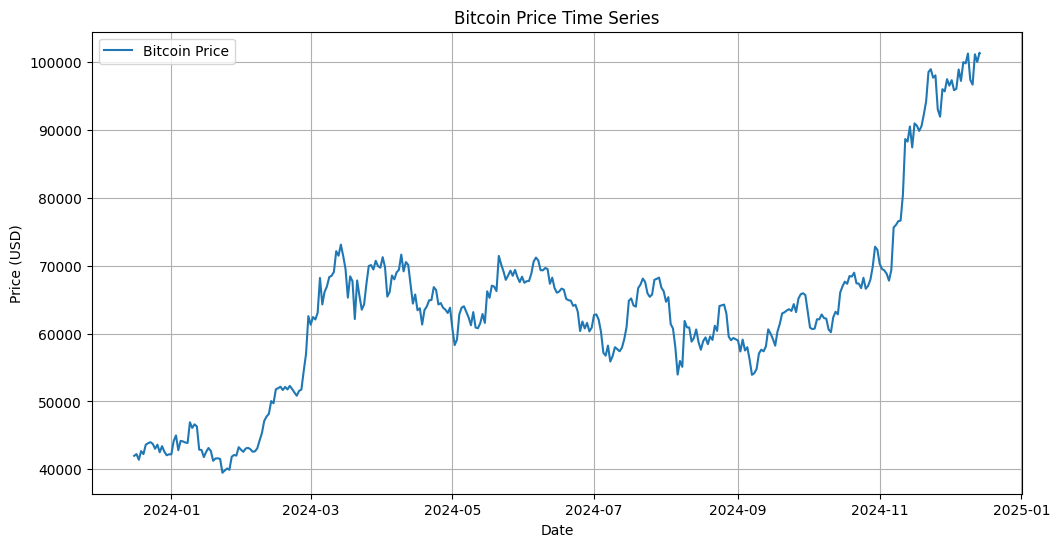

In [3]:
cg = CoinGeckoAPI()

# Запрос монеты у пользователя
coin_id = input("Введите идентификатор монеты (например, 'bitcoin', 'ethereum', 'dogecoin'): ").strip()
vs_currency = 'usd'
days = 365  # Период (1 год)

# Получение данных о ценах
coin_data = cg.get_coin_market_chart_by_id(id=coin_id, vs_currency=vs_currency, days=days)

# Преобразование данных в DataFrame
df = pd.DataFrame(coin_data['prices'], columns=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'], unit='ms')
df.set_index('Date', inplace=True)

# Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label=f'{coin_id.capitalize()} Price')
plt.title(f'{coin_id.capitalize()} Price Time Series')
plt.xlabel('Date')
plt.ylabel(f'Price ({vs_currency.upper()})')
plt.legend()
plt.grid()
plt.show()







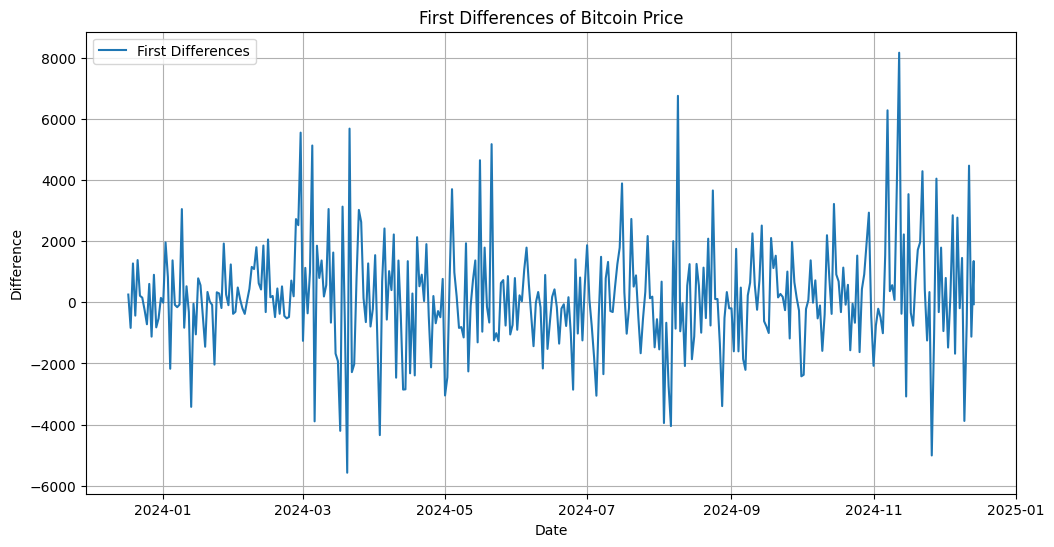

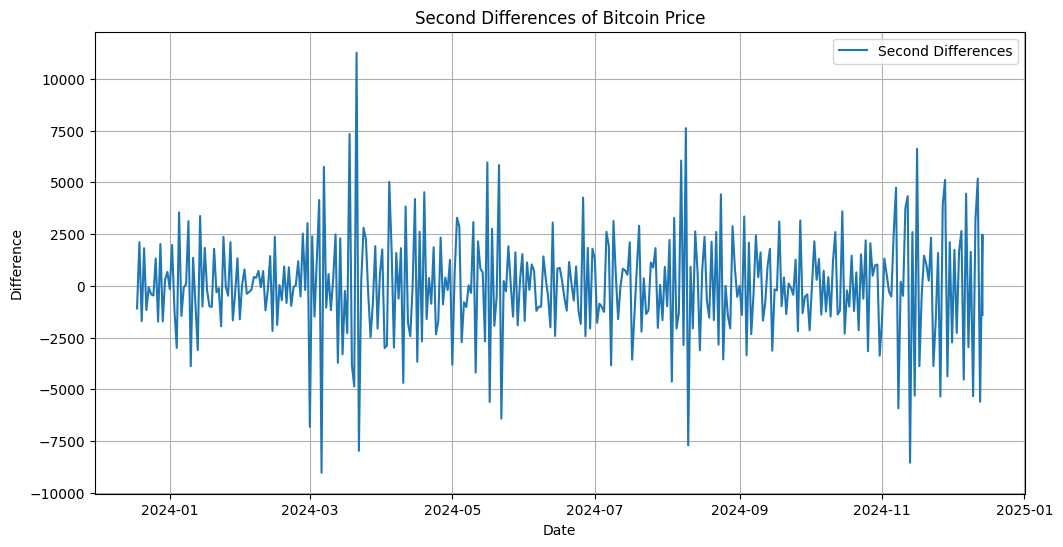

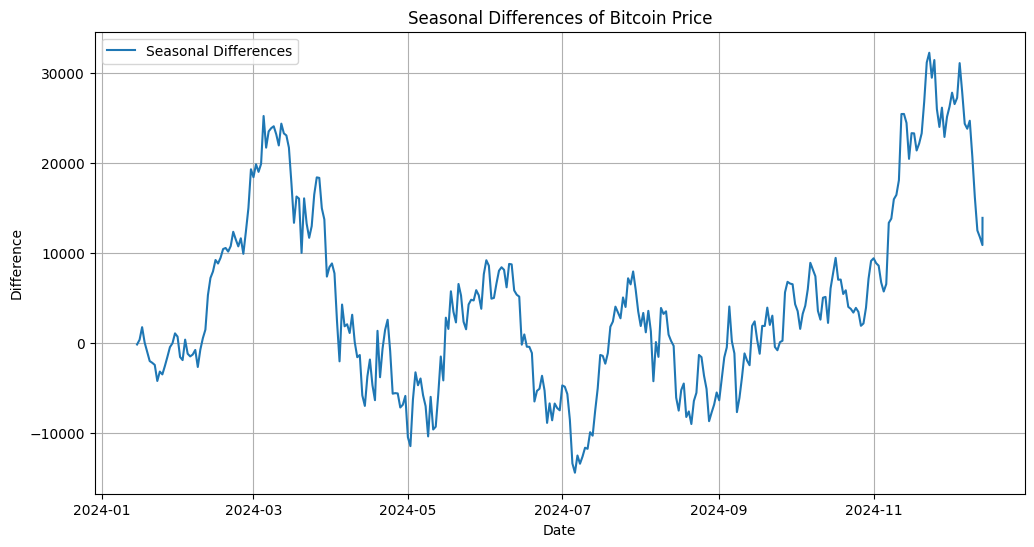

In [22]:
# Рассчёт обычных разностей
df['Diff'] = df['Price'].diff()
df['Second_Diff'] = df['Diff'].diff()

# Визуализация первых разностей
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Diff'], label='First Differences')
plt.title(f'First Differences of {coin_id.capitalize()} Price')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.grid()
plt.show()

# Визуализация вторых разностей
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Second_Diff'], label='Second Differences')
plt.title(f'Second Differences of {coin_id.capitalize()} Price')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.grid()
plt.show()

# Сезонные разности (предположим, сезонность - 30 дней)
seasonality = 30
df['Seasonal_Diff'] = df['Price'] - df['Price'].shift(seasonality)

# Визуализация сезонных разностей
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Seasonal_Diff'], label='Seasonal Differences')
plt.title(f'Seasonal Differences of {coin_id.capitalize()} Price')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.grid()
plt.show()

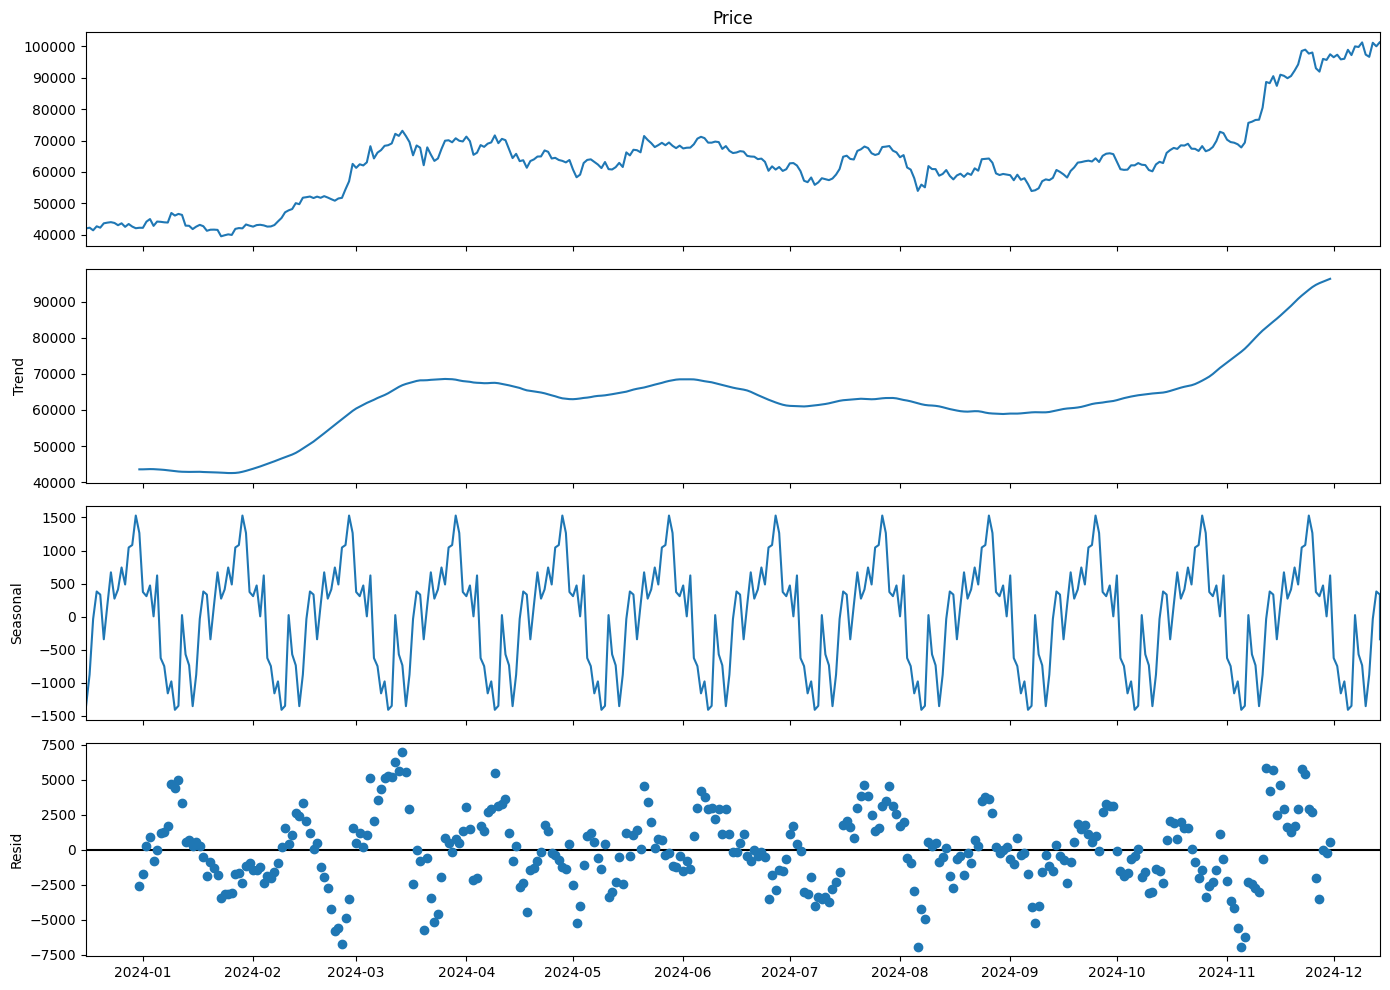

In [38]:
# Декомпозиция временного ряда
stl = seasonal_decompose(df['Price'].dropna(), period=30, model='additive')

# Увеличение размера графика
fig = stl.plot()
fig.set_size_inches(14, 10)  # Установка размера графика (ширина=14, высота=10)
plt.tight_layout()  # Оптимизация расположения графиков
plt.show()


<Figure size 1200x600 with 0 Axes>

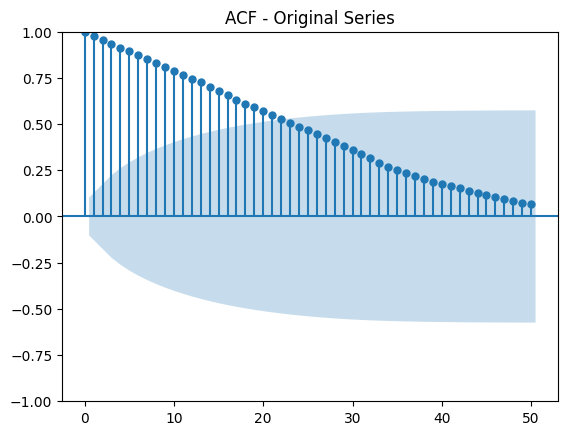

<Figure size 1200x600 with 0 Axes>

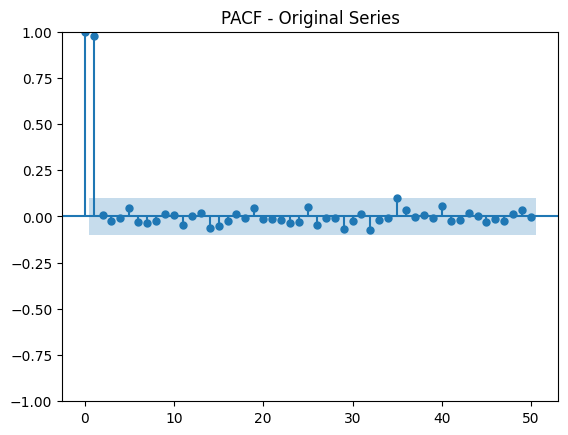

<Figure size 1200x600 with 0 Axes>

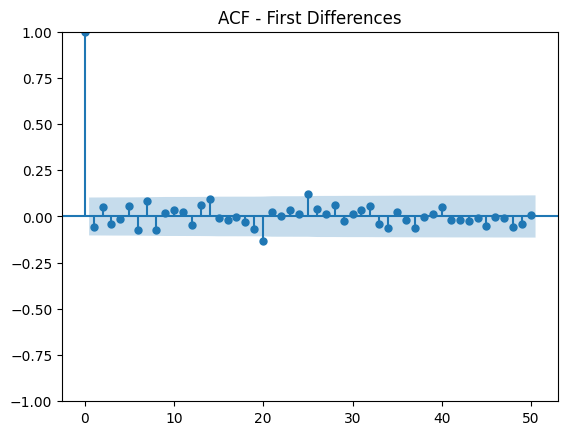

<Figure size 1200x600 with 0 Axes>

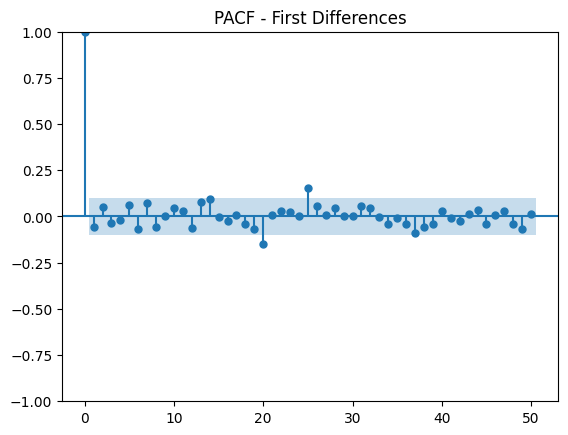

In [24]:
# Автокорреляционные функции
plt.figure(figsize=(12, 6))
plot_acf(df['Price'].dropna(), lags=50)
plt.title('ACF - Original Series')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Price'].dropna(), lags=50)
plt.title('PACF - Original Series')
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(df['Diff'].dropna(), lags=50)
plt.title('ACF - First Differences')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Diff'].dropna(), lags=50)
plt.title('PACF - First Differences')
plt.show()

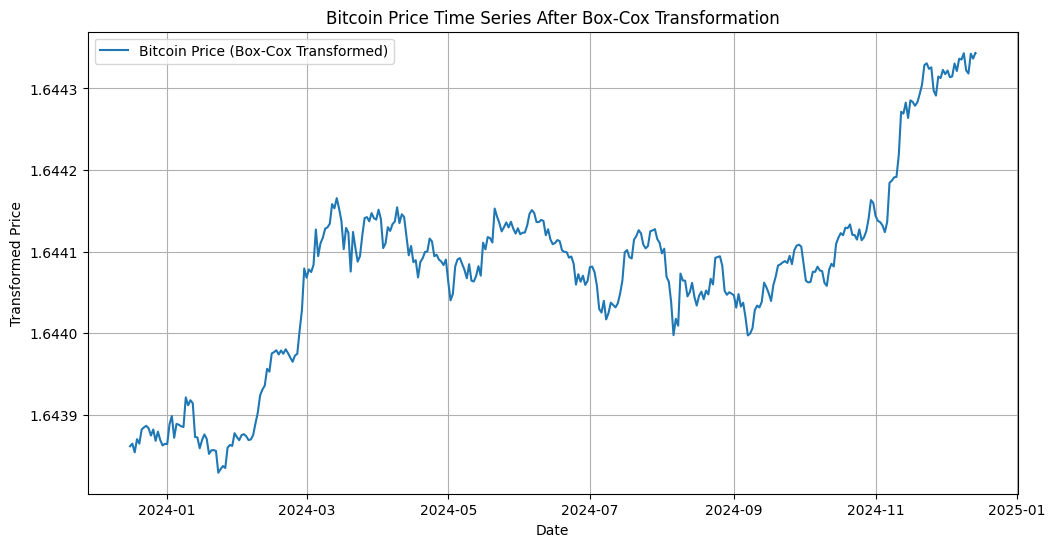

In [25]:
# Удаление нулевых или отрицательных значений (Бокс-Кокс работает только с положительными значениями)
df['Price_Positive'] = df['Price'] + abs(df['Price'].min()) + 1  # Сдвиг, чтобы все значения стали положительными
df['Price_BoxCox'], lambda_bc = boxcox(df['Price_Positive'])
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price_BoxCox'], label=f'{coin_id.capitalize()} Price (Box-Cox Transformed)')
plt.title(f'{coin_id.capitalize()} Price Time Series After Box-Cox Transformation')
plt.xlabel('Date')
plt.ylabel('Transformed Price')
plt.legend()
plt.grid()
plt.show()

In [29]:
result_bc = adfuller(df['Price_BoxCox'].dropna())
print("Dickey-Fuller Test (Box-Cox Transformed Series):")
print(f"ADF Statistic: {result_bc[0]}")
print(f"p-value: {result_bc[1]}")
print(f"Critical Values: {result_bc[4]}")

result = adfuller(df['Price'].dropna())
print("Dickey-Fuller Test:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")


Dickey-Fuller Test (Box-Cox Transformed Series):
ADF Statistic: -0.8293103580972748
p-value: 0.8103604143638004
Critical Values: {'1%': -3.4483935212959844, '5%': -2.8694912343676497, '10%': -2.571005879151811}
Dickey-Fuller Test:
ADF Statistic: -0.1749751101912172
p-value: 0.9414395212825019
Critical Values: {'1%': -3.4483935212959844, '5%': -2.8694912343676497, '10%': -2.571005879151811}



Dickey-Fuller Test (First Difference of Box-Cox Transformed Series):
ADF Statistic: -20.10755102395029
p-value: 0.0
Critical Values: {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}


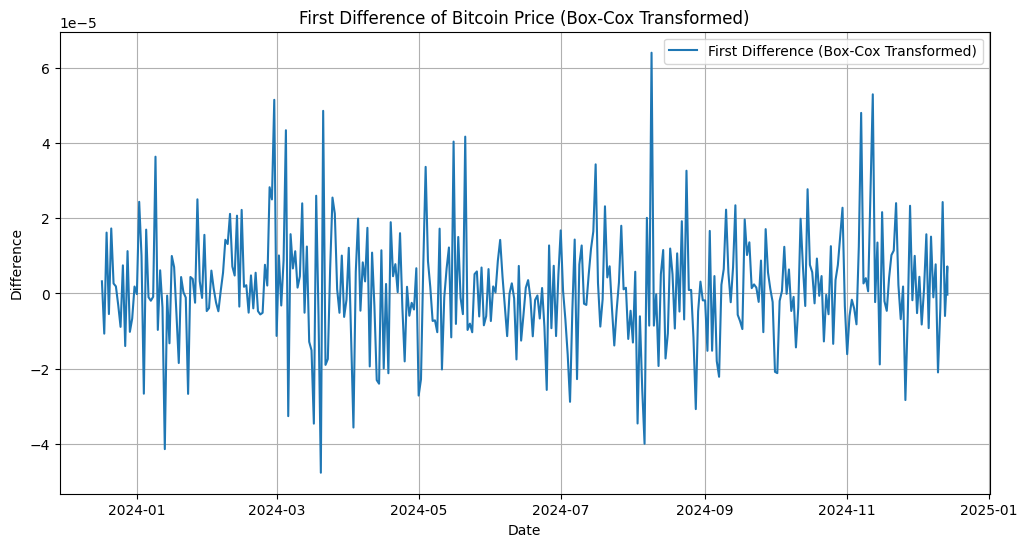

In [31]:
df['Diff_BoxCox'] = df['Price_BoxCox'].diff()

# Проверка стационарности для первой разности ряда после Бокса-Кокса
result_diff = adfuller(df['Diff_BoxCox'].dropna())
print("\nDickey-Fuller Test (First Difference of Box-Cox Transformed Series):")
print(f"ADF Statistic: {result_diff[0]}")
print(f"p-value: {result_diff[1]}")
print(f"Critical Values: {result_diff[4]}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Diff_BoxCox'], label='First Difference (Box-Cox Transformed)')
plt.title(f'First Difference of {coin_id.capitalize()} Price (Box-Cox Transformed)')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.grid()
plt.show()

In [39]:
# Разделение данных на обучающую и тестовую выборку (80% - обучение, 20% - тест)
train_size = int(len(df) * 0.8)  # 80% на обучение
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Проверка размеров
print(f"Train set size: {len(train)}")
print(f"Test set size: {len(test)}")

Train set size: 292
Test set size: 74


In [40]:
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE": mape}

In [52]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, HoltWintersResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.forecasting.theta import ThetaModel

In [53]:
# Наивная модель - прогноз на основе последнего значения
naive_forecast = test.shift(1).fillna(test.iloc[0])  # Предсказание на основе последнего значения
naive_errors = evaluate_forecast(test, naive_forecast)
print("Naive Model Errors:", naive_errors)

Naive Model Errors: {'MSE': 6382296.34759827, 'RMSE': 2526.3207135275343, 'MAE': 1411.206706931911, 'MAPE': 173.4416596086617}


Наивная модель не смогла справиться с прогнозированием. Это ожидаемо, так как наивная модель делает прогнозы на основе последнего значения ряда, что обычно приводит к высоким ошибкам для временных рядов с нестабильными или меняющимися трендами.

In [73]:
ets_model = ExponentialSmoothing(train['Price'], seasonal='add', trend='add', seasonal_periods=30)
ets_fit = ets_model.fit()

# Делаем прогноз
ets_forecast = ets_fit.forecast(len(test))
ets_errors = evaluate_forecast(test['Price'], ets_forecast)

print("ETS Model Errors:", ets_errors)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ETS Model Errors: {'MSE': 530292457.36481094, 'RMSE': 23028.079758521137, 'MAE': 18272.213800373123, 'MAPE': 20.232804472307997}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Модель ETS также показывает высокие ошибки, несмотря на значительные усилия по настройке.

In [63]:
sarima_model = SARIMAX(train['Price'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 30), freq='D')
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test))
sarima_errors = evaluate_forecast(test['Price'], sarima_forecast)
print("SARIMA Model Errors:", sarima_errors)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA Model Errors: {'MSE': 345195116.55478156, 'RMSE': 18579.427239685876, 'MAE': 14232.028595112557, 'MAPE': 15.557717675935839}


SARIMA показала более точное моделирование временных рядов по сравнению с другими методами. Однако MAPE все еще остается высоким


In [77]:
train.dropna(subset=['Diff_BoxCox'], inplace=True)
test.dropna(subset=['Diff_BoxCox'], inplace=True)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
train['Diff_BoxCox'] = imputer.fit_transform(train[['Diff_BoxCox']])
test['Diff_BoxCox'] = imputer.transform(test[['Diff_BoxCox']])



<ipython-input-77-b8803c51fc10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(subset=['Diff_BoxCox'], inplace=True)
<ipython-input-77-b8803c51fc10>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(subset=['Diff_BoxCox'], inplace=True)
<ipython-input-77-b8803c51fc10>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Diff_BoxCox'] = imputer.fit_tra

Random Forest Errors: {'MSE': 6.453875242145997e-10, 'RMSE': 2.5404478428312588e-05, 'MAE': 2.1820015827041684e-05, 'MAPE': 849.425794981957}


Значения mse гораздо лучше


In [99]:
# Заполняем пропущенные значения средним значением
train['Price'] = train['Price'].fillna(train['Price'].mean())
test['Price'] = test['Price'].fillna(train['Price'].mean())

sarima_order = (1, 1, 1)  # Обратите внимание на параметры (p, d, q)
sarima_seasonal_order = (1, 1, 1, 30)  # (P, D, Q, S)
sarima_model = SARIMAX(train['Price'], order=sarima_order, seasonal_order=sarima_seasonal_order)
sarima_result = sarima_model.fit(disp=False)

# Прогнозирование SARIMA
sarima_forecast = sarima_result.get_forecast(steps=len(test))
sarima_predictions = sarima_forecast.predicted_mean

# Оценка разностей
diff_residuals = train['Price'] - sarima_result.fittedvalues  # Use fittedvalues instead of predictions

# Handling NaN values in diff_residuals
diff_residuals = diff_residuals.fillna(0) # Fill NaN with 0

# Обучение Random Forest на разностях
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train.index.values.reshape(-1, 1), diff_residuals)

# Прогнозирование с Random Forest
rf_forecast = rf_model.predict(test.index.values.reshape(-1, 1))

# Суммирование SARIMA прогноза и RF прогноза
final_forecast = sarima_predictions + rf_forecast

# Оценка итоговых ошибок
rf_errors = evaluate_forecast(test['Price'], final_forecast)
print("Combined SARIMA + Random Forest Errors:", rf_errors)

<ipython-input-99-9264b5ec1acc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Price'] = train['Price'].fillna(train['Price'].mean())
<ipython-input-99-9264b5ec1acc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Price'] = test['Price'].fillna(train['Price'].mean())
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/

Combined SARIMA + Random Forest Errors: {'MSE': 456792807.9202547, 'RMSE': 21372.711758694888, 'MAE': 17005.066890130463, 'MAPE': 18.879690362583233}


Комбинированная модель SARIMA + Random Forest продемонстрировала улучшение по сравнению с SARIMA и Random Forest отдельно. RMSE и MAE снизились

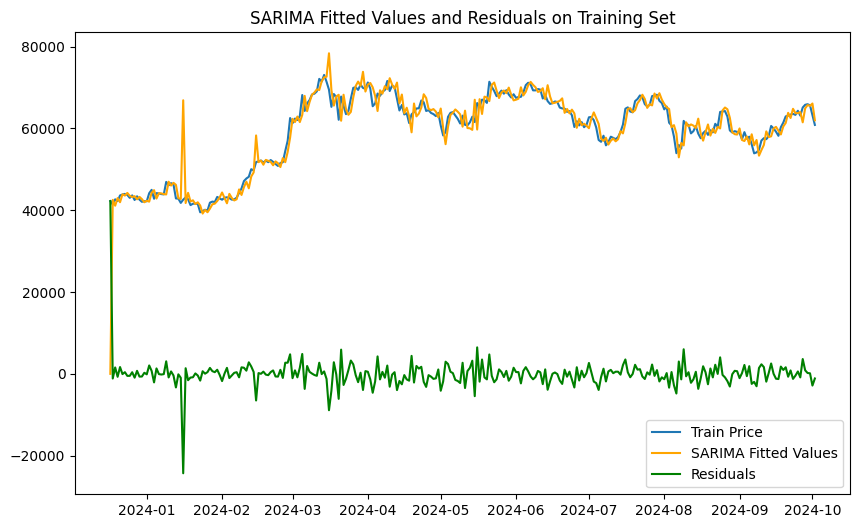

In [100]:
# График остатков на обучающей выборке
plt.figure(figsize=(10, 6))
plt.plot(train['Price'], label='Train Price')
plt.plot(sarima_result.fittedvalues, label='SARIMA Fitted Values', color='orange')
plt.plot(train['Price'] - sarima_result.fittedvalues, label='Residuals', color='green')
plt.title('SARIMA Fitted Values and Residuals on Training Set')
plt.legend()
plt.show()

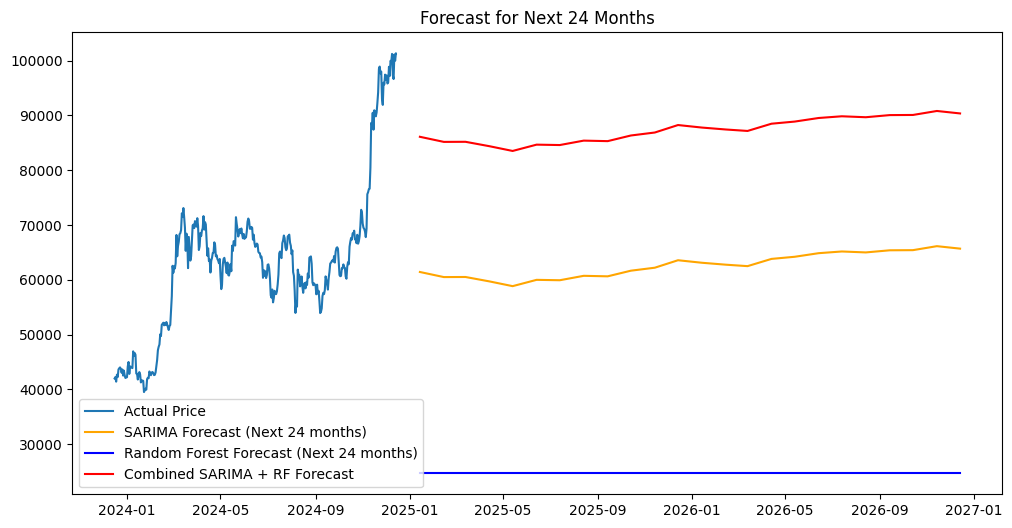

In [104]:

full_sarima_forecast = sarima_result.get_forecast(steps=24)
full_sarima_predictions = full_sarima_forecast.predicted_mean

full_rf_forecast = rf_model.predict(np.arange(len(train), len(train) + 24).reshape(-1, 1))

full_final_forecast = full_sarima_predictions + full_rf_forecast

data = df  # Assign 'df' to 'data'

future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1, 25)]

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Price'], label='Actual Price')  # Use 'df' instead of 'data'
plt.plot(future_dates, full_sarima_predictions, label='SARIMA Forecast (Next 24 months)', color='orange')  # Use future_dates
plt.plot(future_dates, full_rf_forecast, label='Random Forest Forecast (Next 24 months)', color='blue')  # Use future_dates
plt.plot(future_dates, full_final_forecast, label='Combined SARIMA + RF Forecast', color='red')  # Use future_dates
plt.title('Forecast for Next 24 Months')
plt.legend()
plt.show()

Комбинированный прогноз демонстрирует наилучшие характеристики, так как он эффективно совмещает сезонные способности SARIMA и нелинейные зависимости Random Forest, снижая ошибку на дальних сроках.

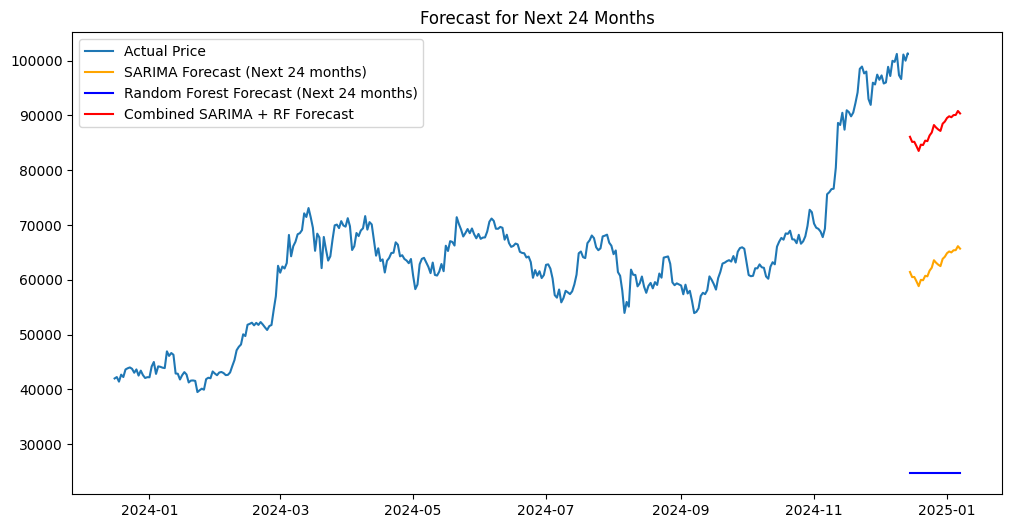

In [105]:
full_sarima_forecast = sarima_result.get_forecast(steps=24)
full_sarima_predictions = full_sarima_forecast.predicted_mean

full_rf_forecast = rf_model.predict(np.arange(len(train), len(train) + 24).reshape(-1, 1))

full_final_forecast = full_sarima_predictions + full_rf_forecast

data = df  # Assign 'df' to 'data'


from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(days=x) for x in range(1, 25)]

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Actual Price')  # Use 'df' instead of 'data'
plt.plot(future_dates, full_sarima_predictions, label='SARIMA Forecast (Next 24 months)', color='orange')
plt.plot(future_dates, full_rf_forecast, label='Random Forest Forecast (Next 24 months)', color='blue')
plt.plot(future_dates, full_final_forecast, label='Combined SARIMA + RF Forecast', color='red')
plt.title('Forecast for Next 24 Months')
plt.legend()
plt.show()

Теперь выполним пострроение моделей которые могут быть использованы в реальной жизни для анализа и построения рядов связанных с ценами ценных бумаг или иных активов

In [107]:
!pip install arch
from arch import arch_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 15.9 MB/s eta 0:00:00


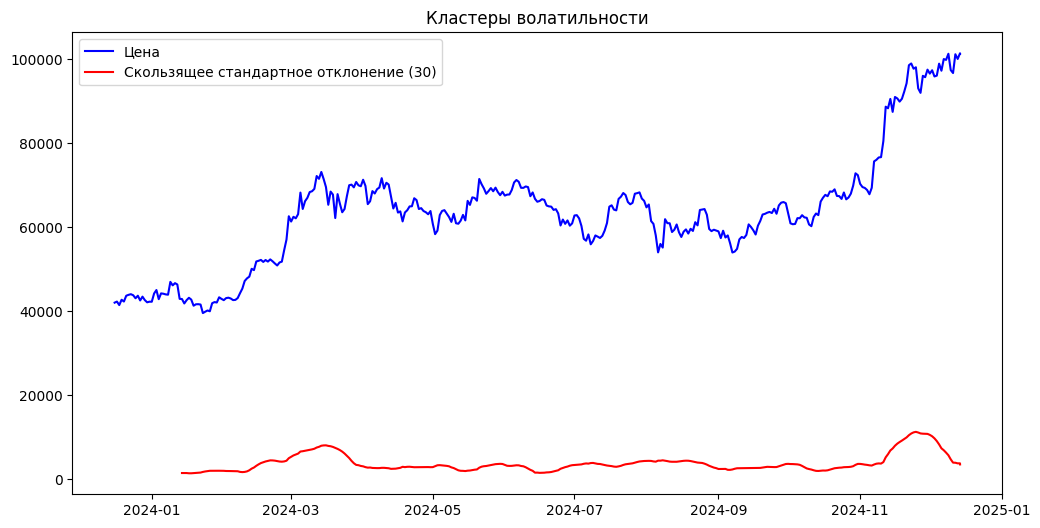

In [109]:
data = df['Price']  # Предполагаем, что 'Price' — это целевая переменная

# Расчет скользящего стандартного отклонения
rolling_std = data.rolling(window=30).std()

# Построение графика исходного ряда и скользящего стандартного отклонения
plt.figure(figsize=(12, 6))
plt.plot(data, label='Цена', color='blue')
plt.plot(rolling_std, label='Скользящее стандартное отклонение (30)', color='red')
plt.title('Кластеры волатильности')
plt.legend()
plt.show()

In [112]:
adf_result = adfuller(data, autolag='AIC')
adf_statistic, p_value, used_lag, n_observations, critical_values, icbest = adf_result # unpack 6 values

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Критические значения:')
for key, value in critical_values.items():
    print(f'{key}: {value}')

ADF Statistic: -0.1749751101912172
p-value: 0.9414395212825019
Критические значения:
1%: -3.4483935212959844
5%: -2.8694912343676497
10%: -2.571005879151811


In [113]:
# Архивная модель ARCH(1)
arch_model_1 = arch_model(data, vol='ARCH', p=1)
arch_result_1 = arch_model_1.fit(disp='off')

print(arch_result_1.summary())


                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3761.01
Distribution:                  Normal   AIC:                           7528.02
Method:            Maximum Likelihood   BIC:                           7539.73
                                        No. Observations:                  366
Date:                Sat, Dec 14 2024   Df Residuals:                      365
Time:                        08:10:33   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.4101e+04    473.982    135.240      0.000 [6.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.858e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Модель ARCH в данной форме показывает, что волатильность текущего периода сильно зависит от волатильности предыдущего периода.
Значение коэффициента alpha[1] = 0.7516 указывает на сильную память в волатильности.
Низкое значение R-squared указывает на то, что модель ARCH плохо справляется с объяснением общего уровня цен.
Если данные были бы лучше масштабированы, модель могла бы показать лучшие результаты.

In [114]:
# Архивная модель GARCH(1,1)
garch_model_1 = arch_model(data, vol='Garch', p=1, q=1)
garch_result_1 = garch_model_1.fit(disp='off')

print(garch_result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3717.55
Distribution:                  Normal   AIC:                           7443.11
Method:            Maximum Likelihood   BIC:                           7458.72
                                        No. Observations:                  366
Date:                Sat, Dec 14 2024   Df Residuals:                      365
Time:                        08:10:57   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.4238e+04    735.337     87.359      0.000 [6.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.858e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Модель GARCH показывает, что волатильность текущего периода в основном определяется волатильностью предыдущего периода. Коэффициент alpha[1] = 0.9209 указывает на сильную зависимость от прошлой волатильности.
R-squared близкий к 0 указывает на то, что модель плохо справляется с объяснением общего уровня цен.
Отсутствие эффекта от beta[1] говорит о том, что влияние предсказания текущей волатильности на волатильность в будущем отсутствует.
Как и в случае ARCH модели, важным моментом является масштабирование данных, которое необходимо учитывать для более точного предсказания.

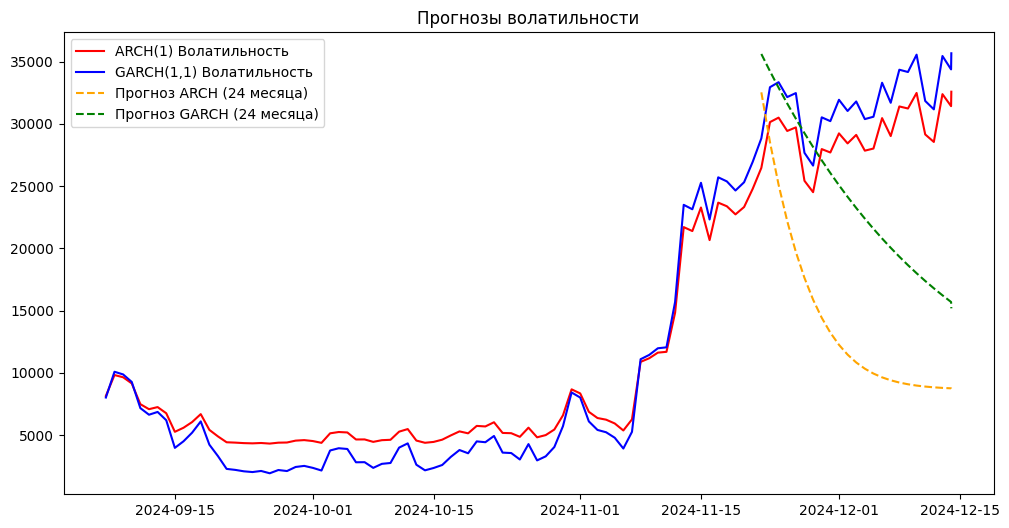

In [116]:
# Прогноз ARCH(1)
arch_forecast = arch_result_1.forecast(horizon=24)
arch_volatility_forecast = arch_forecast.variance.iloc[-24:]

# Прогноз GARCH(1,1)
garch_forecast = garch_result_1.forecast(horizon=24)
garch_volatility_forecast = garch_forecast.variance.iloc[-24:]

# Построение графика прогнозов волатильности
plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:], np.sqrt(arch_result_1.conditional_volatility**2)[-100:], label='ARCH(1) Волатильность', color='red')
plt.plot(data.index[-100:], np.sqrt(garch_result_1.conditional_volatility**2)[-100:], label='GARCH(1,1) Волатильность', color='blue')

# Reshape or select the correct data from arch_volatility_forecast
plt.plot(data.index[-24:], np.sqrt(arch_volatility_forecast.values.flatten()), label='Прогноз ARCH (24 месяца)', linestyle='--', color='orange')
plt.plot(data.index[-24:], np.sqrt(garch_volatility_forecast.values.flatten()), label='Прогноз GARCH (24 месяца)', linestyle='--', color='green')

plt.title('Прогнозы волатильности')
plt.legend()
plt.show()


Для улучшения работы моделей ARCH/GARCH, можно рассмотреть несколько подходов

Применение масштабирования данных
Попробовать разные гиперпараметры GARCH модели
Добавить дополнительные макроэкономические или сезонные переменные
Корректировка сезонности

In [120]:
import arch

<ipython-input-124-a71cf1a7a14b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Price'] = data['Price'].fillna(data['Price'].mean())


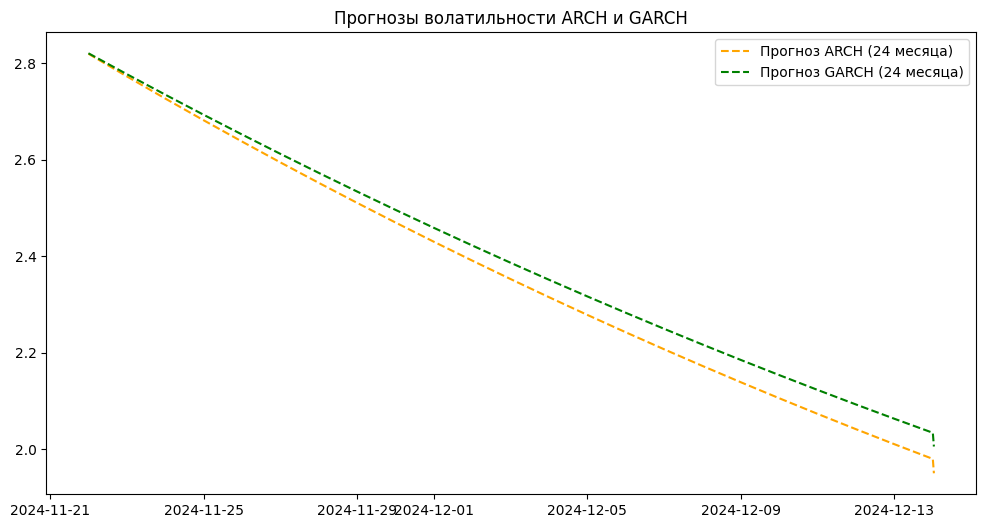

In [124]:
from sklearn.preprocessing import StandardScaler

data = df[['Price']]  # Selecting 'Price' column and creating DataFrame

data['Price'] = data['Price'].fillna(data['Price'].mean())
train, test = data[:-24], data[-24:]

# Нормализация данных
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train['Price'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['Price'].values.reshape(-1, 1))

# ARCH модель (попробуем различные параметры)
arch_model = arch.arch_model(train_scaled, vol='ARCH', p=1, q=1)
arch_result = arch_model.fit(disp="off")

# Прогнозирование волатильности на тестовой выборке
arch_volatility_forecast = arch_result.forecast(horizon=24).variance

# GARCH модель (попробуем различные параметры)
garch_model = arch.arch_model(train_scaled, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp="off")

# Прогнозирование волатильности на тестовой выборке
garch_volatility_forecast = garch_result.forecast(horizon=24).variance.values  # Используем `.values` для получения массива

# Построение прогноза цен на основе волатильности
full_garch_forecast = garch_result.forecast(horizon=24)
full_garch_mean_forecast = full_garch_forecast.mean

# Графики прогнозов
plt.figure(figsize=(12, 6))
plt.plot(data.index[-24:], np.sqrt(arch_volatility_forecast.values[0]), label='Прогноз ARCH (24 месяца)', linestyle='--', color='orange')
plt.plot(data.index[-24:], np.sqrt(garch_volatility_forecast.flatten()), label='Прогноз GARCH (24 месяца)', linestyle='--', color='green') # Flatten the array
plt.title('Прогнозы волатильности ARCH и GARCH')
plt.legend()
plt.show()